In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib 
import math
from matplotlib.ticker import FuncFormatter
from scipy import stats
import matplotlib.colors as mcolors

'''
192.168.0.24: intensity context (old task), duration context (new task)
192.168.0.29: click rate task (old task), sweep direction (new task)
'''

'\n192.168.0.24: intensity context (old task), duration context (new task)\n192.168.0.29: click rate task (old task), sweep direction (new task)\n'

In [3]:
'''
For the intensity vs. click rate task, first few CLIK trials were corrupted, drop them
'''
ALL = pd.read_csv("data/ALL_6.20.25.csv").iloc[:,1:]
ALL = ALL.dropna()
ALL['times'] = pd.to_datetime(ALL['times'],format='%Y-%m-%d %H:%M:%S.%f',)             # any bad rows become NaT
ALL['day'] = ALL['times'].dt.normalize()   # midnight of each day
all_days = ALL["day"].dt.date.unique()
subject_IDs = np.sort(ALL.subjects.unique())
# find the two tasks
INTENSITY = ALL[ALL.task == 24].reset_index(drop=True)
CLICKS = ALL[ALL.task == 29].reset_index(drop=True)

# Filter out the contaminated trials (approx. 500 trials)
# INTENSITY = INTENSITY[500:]
CLICKS = CLICKS[500:]
ALL = pd.concat([INTENSITY, CLICKS]).reset_index(drop=True)

# load context-dependent and invariant trials for each task
INVARIANT_INTENSITY = INTENSITY[
    (INTENSITY['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (INTENSITY['specific_stims'] == 'clicks_32hz_1s_70db.wav')
]
DEPENDENT_INTENSITY = INTENSITY[
    (INTENSITY['specific_stims'] == 'clicks_12hz_1s_70db.wav')
    | 
    (INTENSITY['specific_stims'] == 'clicks_32hz_1s_60db.wav')
]

INVARIANT_CLICKS = CLICKS[
    (CLICKS['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (CLICKS['specific_stims'] == 'clicks_32hz_1s_70db.wav')
]
DEPENDENT_CLICKS = CLICKS[
    (CLICKS['specific_stims'] == 'clicks_12hz_1s_70db.wav')
    | 
    (CLICKS['specific_stims'] == 'clicks_32hz_1s_60db.wav')
]

In [4]:
colors = ['#FFC07F', # Arena A
          '#94c47d', #  Arena B
          '#4AA9FC', # context-dep
          "#A1A7B0"] # context-inv

# Plot animal 41 for Grant

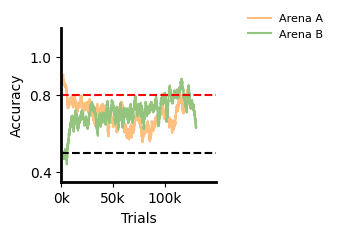

In [5]:
# plot the overall performance in both tasks
roll_size = 200
matplotlib.rcParams['font.size'] = 10

subject = subject_IDs[0]
colors = ['#FFC07F', # Arena A
          '#94c47d', #  Arena B
          '#4AA9FC', # context-dep
          "#A1A7B0"] # context-inv

# overall performance
fig = plt.figure(figsize=(2,2))
ax = plt.subplot(1,1,1)
sub_intensity = INTENSITY.loc[INTENSITY.subjects == subject].reset_index(drop=True)
sub_intensity.outcomes.rolling(roll_size).mean().plot(ax=ax,label="Arena A", color=colors[0])
sub_clicks = CLICKS.loc[CLICKS.subjects == subject].reset_index(drop=True)
sub_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="Arena B", color=colors[1])
ax.axhline(0.8, color='red', ls='--')
ax.axhline(0.5, color='black', ls='--')
x_max = max(len(sub_intensity), len(sub_clicks))
if x_max < 15000:
    lim_x = 15000
else:
    lim_x = math.ceil(x_max / 5000) * 5000
ax.set_xlim(0, lim_x) 
ax.set_xticks(np.arange(0, lim_x+1, 5000))
ax.set_xlabel('Trials')
# ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f'{x/100:.0f}k'))
last_tick  = ax.xaxis.get_major_ticks()[-1]   # grab final Tick object
last_tick.set_visible(False)
ax.set_ylim(0.35, 1.15)  
ax.set_ylabel("Accuracy")
ax.set_yticks(np.arange(0.4, 1.1, 0.2))

ax.yaxis.get_major_ticks()[1].set_visible(False)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper left',    # position above all subplots
    ncol=1,                # number of columns in the legend
    bbox_to_anchor=(1.01, 1),
    fontsize = 8,
    frameon = False
)
# plt.savefig('figures/overall_performance.pdf',bbox_inches='tight')
plt.show()


**bar plot of peak performance**

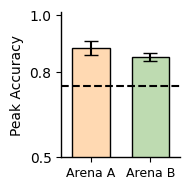

In [6]:
def daily_accuracy(df):
    """Return one row per day with accuracy *and* trial count."""
    return (df.groupby('day')['outcomes']
              .agg(accuracy='mean', n='size')       # <- add n
              .reset_index())
def mean_sem(series):
    mean = series.mean()
    sem  = series.std(ddof=1) / np.sqrt(len(series))
    return mean, sem

rng =np.random.default_rng(1)
intensity_day = daily_accuracy(sub_intensity)    # Arena A
click_day     = daily_accuracy(sub_clicks)        # Arena B

k = 5
top_intensity = intensity_day.nlargest(k, 'accuracy')
top_click     = click_day.nlargest(k, 'accuracy')

face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[1], 0.6)

mean_A, sem_A = mean_sem(top_intensity['accuracy'])
mean_B, sem_B = mean_sem(top_click['accuracy'])

x        = [0.2, 0.6]
means    = [mean_A,  mean_B]
errors   = [sem_A,   sem_B]
labels   = ['Arena A', 'Arena B']

fig, ax = plt.subplots(figsize=(2, 2))
ax.bar(x, means, yerr=errors, capsize=5,
       width=0.25, color = [face_A, face_B], edgecolor='black')

ax.set_xticks(x,labels,fontsize = 9)
ax.set_xlim(0, 0.8)  
ax.set_ylim(0.5, 1.01)  
ax.set_ylabel("Peak Accuracy")
ax.set_yticks([0.5, 0.8, 1.0])
# ax.yaxis.get_major_ticks()[1].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.scatter(
#     x[0]+ rng.uniform(-0.01, 0.01, len(top_intensity.accuracy)), top_intensity.accuracy,
#     marker='o',
#     s=20,
#     facecolors=colors[0],   # your orange
#     edgecolors='black',
#     linewidths=0.8,
#     zorder=2
# )

# ax.scatter(
#     x[1]+ rng.uniform(-0.01, 0.01, len(top_click.accuracy)), top_click.accuracy,
#     marker='o',
#     s=20,
#     facecolors=colors[1],   # your orange
#     edgecolors='black',
#     linewidths=0.8,
#     zorder=2
# )
ax.axhline(0.75, color='black', ls='--')

plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/peak_performance.svg',bbox_inches='tight', format = 'svg')
plt.show()

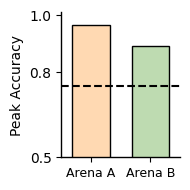

In [8]:
def daily_accuracy(df):
    """Return one row per day with accuracy *and* trial count."""
    return (df.groupby('day')['outcomes']
              .agg(accuracy='mean', n='size')       # <- add n
              .reset_index())
def mean_sem(series):
    mean = series.mean()
    sem  = series.std(ddof=1) / np.sqrt(len(series))
    return mean, sem

rng =np.random.default_rng(1)
intensity_day = daily_accuracy(sub_intensity)    # Arena A
click_day     = daily_accuracy(sub_clicks)        # Arena B

k = 1
top_intensity = intensity_day.nlargest(k, 'accuracy')
top_click     = click_day.nlargest(k, 'accuracy')

face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[1], 0.6)

mean_A, sem_A = mean_sem(top_intensity['accuracy'])
mean_B, sem_B = mean_sem(top_click['accuracy'])

x        = [0.2, 0.6]
means    = [mean_A,  mean_B]
errors   = [sem_A,   sem_B]
labels   = ['Arena A', 'Arena B']

fig, ax = plt.subplots(figsize=(2, 2))
ax.bar(x, means, yerr=errors, capsize=5,
       width=0.25, color = [face_A, face_B], edgecolor='black')

ax.set_xticks(x,labels,fontsize = 9)
ax.set_xlim(0, 0.8)  
ax.set_ylim(0.5, 1.01)  
ax.set_ylabel("Peak Accuracy")
ax.set_yticks([0.5, 0.8, 1.0])
# ax.yaxis.get_major_ticks()[1].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.scatter(
#     x[0]+ rng.uniform(-0.01, 0.01, len(top_intensity.accuracy)), top_intensity.accuracy,
#     marker='o',
#     s=20,
#     facecolors=colors[0],   # your orange
#     edgecolors='black',
#     linewidths=0.8,
#     zorder=2
# )

# ax.scatter(
#     x[1]+ rng.uniform(-0.01, 0.01, len(top_click.accuracy)), top_click.accuracy,
#     marker='o',
#     s=20,
#     facecolors=colors[1],   # your orange
#     edgecolors='black',
#     linewidths=0.8,
#     zorder=2
# )

ax.axhline(0.75, color='black', ls='--')

plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/one_peak_performance.svg',bbox_inches='tight', format = 'svg')
plt.show()

**Effective chance level in top 5 sessions: animal use purely context-invariant strategy**

In [9]:
keep_days = set(top_intensity['day']).union(top_click['day'])

subject_data = pd.concat([sub_intensity, sub_clicks])
df_sub = subject_data[subject_data['day'].isin(keep_days)].copy()

CI = {'clicks_32hz_1s_70db.wav', 'clicks_12hz_1s_60db.wav'}
df_sub['stim_class'] = np.where(df_sub['specific_stims'].isin(CI), 'CI', 'CD')


# 4)  Monte-Carlo: on every iteration, randomly commit to Arena-A rule (task 24)
#     OR Arena-B rule (task 29), then score every trial in df_sub.
def accuracy_random_rule(dataframe, n_iter=10_000, seed=0):
    rng   = np.random.default_rng(seed)
    arena = dataframe['task'].to_numpy()          # 24 = A, 29 = B
    stimC = dataframe['stim_class'].to_numpy()

    accs = np.empty(n_iter)
    for i in range(n_iter):
        rule = rng.choice([24, 29])               # 50:50 pick A- or B-rule
        correct = (
            (stimC == 'CI') |                     # CI always correct
            ((stimC == 'CD') & (arena == rule))   # CD correct only in chosen arena
        )
        accs[i] = correct.mean()

    mean_acc = accs.mean()
    sd_acc   = accs.std(ddof=1)
    ci95     = 1.96 * sd_acc / np.sqrt(n_iter)
    return df_sub, mean_acc, ci95

df_sub, mean_acc, ci95 = accuracy_random_rule(df_sub)

print(f"Chance level (top-5 sessions only length({len(df_sub)})): {mean_acc:.5f} ± {ci95:.7f}  (95 % CI)")

Chance level (top-5 sessions only length(326)): 0.75458 ± 0.0000601  (95 % CI)


**bar plot of peak performance for context-invariant and -dependent stimuli**

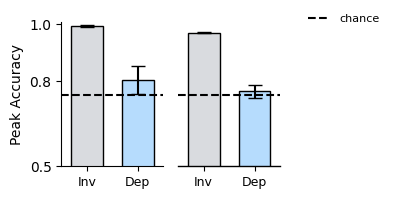

In [10]:
def top_k_stats(df, k=5):
    """accuracy ± SEM for the k best days in df"""
    day_tbl = daily_accuracy(df)
    day_tbl = day_tbl[day_tbl['n'] >= 20]      # length criterion

    if day_tbl.empty:
        raise ValueError("No sessions meet the ≥{}-trials criterion.".format(20))

    best = day_tbl.nlargest(min(k, len(day_tbl)), 'accuracy')
    return mean_sem(best['accuracy']), best

# ------------------------------------------------------------------
# 1.  get mean ± SEM for each of the four dataframes ---------------
# ------------------------------------------------------------------
sub_inv_intensity = INVARIANT_INTENSITY.loc[INVARIANT_INTENSITY.subjects == subject].reset_index(drop=True)
sub_dep_intensity = DEPENDENT_INTENSITY.loc[DEPENDENT_INTENSITY.subjects == subject].reset_index(drop=True)
sub_inv_clicks = INVARIANT_CLICKS.loc[INVARIANT_CLICKS.subjects == subject].reset_index(drop=True)
sub_dep_clicks = DEPENDENT_CLICKS.loc[DEPENDENT_CLICKS.subjects == subject].reset_index(drop=True)

(kA, best_inv_A), (kB, best_dep_A) = [top_k_stats(d) for d in (sub_inv_intensity, sub_dep_intensity)]
(kC, best_inv_B), (kD, best_dep_B) = [top_k_stats(d) for d in (sub_inv_clicks, sub_dep_clicks)]

mean_inv_A, sem_inv_A = kA
mean_dep_A, sem_dep_A = kB
mean_inv_B, sem_inv_B = kC
mean_dep_B, sem_dep_B = kD

face_A = mcolors.to_rgba(colors[3], 0.4)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[2], 0.4)

# ------------------------------------------------------------------
# 2.  FIGURE 1 – Arena A (Intensity) -------------------------------
# ------------------------------------------------------------------
fig = plt.figure(figsize=(3,2))
ax = plt.subplot(1, 2, 1)
x = [0.2, 0.6]
ax.bar(x, [mean_inv_A, mean_dep_A],
       yerr=[sem_inv_A, sem_dep_A],
       width=0.25, capsize=5,
       color=[face_A, face_B],edgecolor='black')

ax.set_xticks(x, ['Inv', 'Dep'] , fontsize=9)
ax.set_ylim(0.5, 1.01)  
ax.set_xlim(0, 0.8)
ax.set_ylabel("Peak Accuracy")
ax.set_yticks([0.5, 0.8, 1.0])
# ax.set_title('Arena A', fontsize=10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.axhline(0.75, color='black', ls='--')
plt.tight_layout()

# ------------------------------------------------------------------
# 3.  FIGURE 2 – Arena B (Clicks) ----------------------------------
# ------------------------------------------------------------------
ax = plt.subplot(1, 2, 2)
ax.bar(x, [mean_inv_B, mean_dep_B],
       yerr=[sem_inv_B, sem_dep_B],
       width=0.25, capsize=5,
       color=[face_A, face_B],edgecolor='black')

ax.set_xticks(x, ['Inv', 'Dep'] , fontsize=9)
ax.set_ylim(0.5, 1.01)  
ax.set_xlim(0, 0.8)
ax.set_ylabel("Peak Accuracy")
ax.set_yticks([0.5, 0.8, 1.0])
# ax.set_title('Arena B', fontsize=10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False) 
ax.axhline(0.75, color='black', ls='--',label='chance')

fig.legend(
    loc='upper left',    # position above all subplots
    ncol=1,                # number of columns in the legend
    bbox_to_anchor=(1.01, 1),
    fontsize = 8,
    frameon = False,
)

plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/stim_specific_peak_performance.svg',bbox_inches='tight', format = 'svg')
plt.show()

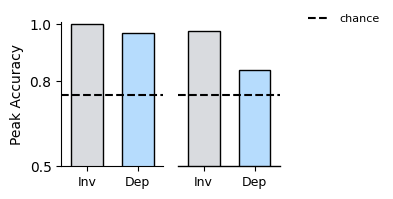

In [11]:
def top_k_stats(df, k=1):
    """accuracy ± SEM for the k best days in df"""
    day_tbl = daily_accuracy(df)
    day_tbl = day_tbl[day_tbl['n'] >= 20]      # length criterion

    if day_tbl.empty:
        raise ValueError("No sessions meet the ≥{}-trials criterion.".format(20))

    best = day_tbl.nlargest(min(k, len(day_tbl)), 'accuracy')
    return mean_sem(best['accuracy']), best

# ------------------------------------------------------------------
# 1.  get mean ± SEM for each of the four dataframes ---------------
# ------------------------------------------------------------------
sub_inv_intensity = INVARIANT_INTENSITY.loc[INVARIANT_INTENSITY.subjects == subject].reset_index(drop=True)
sub_dep_intensity = DEPENDENT_INTENSITY.loc[DEPENDENT_INTENSITY.subjects == subject].reset_index(drop=True)
sub_inv_clicks = INVARIANT_CLICKS.loc[INVARIANT_CLICKS.subjects == subject].reset_index(drop=True)
sub_dep_clicks = DEPENDENT_CLICKS.loc[DEPENDENT_CLICKS.subjects == subject].reset_index(drop=True)

(kA, best_inv_A), (kB, best_dep_A) = [top_k_stats(d) for d in (sub_inv_intensity, sub_dep_intensity)]
(kC, best_inv_B), (kD, best_dep_B) = [top_k_stats(d) for d in (sub_inv_clicks, sub_dep_clicks)]

mean_inv_A, sem_inv_A = kA
mean_dep_A, sem_dep_A = kB
mean_inv_B, sem_inv_B = kC
mean_dep_B, sem_dep_B = kD

face_A = mcolors.to_rgba(colors[3], 0.4)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[2], 0.4)

# ------------------------------------------------------------------
# 2.  FIGURE 1 – Arena A (Intensity) -------------------------------
# ------------------------------------------------------------------
fig = plt.figure(figsize=(3,2))
ax = plt.subplot(1, 2, 1)
x = [0.2, 0.6]
ax.bar(x, [mean_inv_A, mean_dep_A],
       yerr=[sem_inv_A, sem_dep_A],
       width=0.25, capsize=5,
       color=[face_A, face_B],edgecolor='black')

ax.set_xticks(x, ['Inv', 'Dep'] , fontsize=9)
ax.set_ylim(0.5, 1.01)  
ax.set_xlim(0, 0.8)
ax.set_ylabel("Peak Accuracy")
ax.set_yticks([0.5, 0.8, 1.0])
# ax.set_title('Arena A', fontsize=10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.axhline(0.75, color='black', ls='--')
plt.tight_layout()

# ------------------------------------------------------------------
# 3.  FIGURE 2 – Arena B (Clicks) ----------------------------------
# ------------------------------------------------------------------
ax = plt.subplot(1, 2, 2)
ax.bar(x, [mean_inv_B, mean_dep_B],
       yerr=[sem_inv_B, sem_dep_B],
       width=0.25, capsize=5,
       color=[face_A, face_B],edgecolor='black')

ax.set_xticks(x, ['Inv', 'Dep'] , fontsize=9)
ax.set_ylim(0.5, 1.01)  
ax.set_xlim(0, 0.8)
ax.set_ylabel("Peak Accuracy")
ax.set_yticks([0.5, 0.8, 1.0])
# ax.set_title('Arena B', fontsize=10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False) 
ax.axhline(0.75, color='black', ls='--',label='chance')

fig.legend(
    loc='upper left',    # position above all subplots
    ncol=1,                # number of columns in the legend
    bbox_to_anchor=(1.01, 1),
    fontsize = 8,
    frameon = False,
)

plt.tight_layout()

plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/stim_specific_one_peak_performance.svg',bbox_inches='tight', format = 'svg')
plt.show()

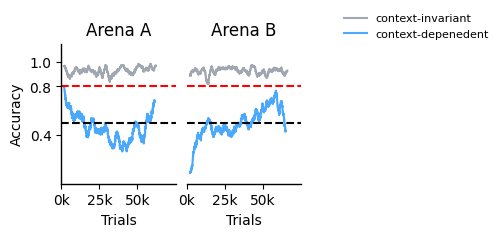

In [22]:
''' 
Plot context-dep or inv stimuli accuracy separately
'''
roll_size = 200
# Task intensity
fig = plt.figure(figsize=(3,2))

ax = plt.subplot(1, 2, 1)
sub_inv_intensity = INVARIANT_INTENSITY.loc[INVARIANT_INTENSITY.subjects == subject].reset_index(drop=True)
sub_inv_intensity.outcomes.rolling(roll_size,).mean().plot(ax=ax,label="Invariant", color=colors[3])
sub_dep_intensity = DEPENDENT_INTENSITY.loc[DEPENDENT_INTENSITY.subjects == subject].reset_index(drop=True)
sub_dep_intensity.outcomes.rolling(roll_size).mean().plot(ax=ax,label="Dependent", color=colors[2])
ax.axhline(0.8, color='red', ls='--')
ax.axhline(0.5, color='black', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
x_max = max(len(sub_inv_intensity), len(sub_dep_intensity))
if x_max < 5500:
    lim_x = 5500
else:
    lim_x = math.ceil(x_max / 2500) * 2500
ax.set_xlim(0, lim_x) 
ax.set_xticks(np.arange(0, lim_x+1, 2500))
# ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f'{x/100:.0f}k'))
last_tick  = ax.xaxis.get_major_ticks()[-1]   # grab final Tick object
last_tick.set_visible(False)
ax.set_ylim(0, 1.15)  
ax.set_yticks(np.arange(0, 1.1, 0.2))

ax.yaxis.get_major_ticks()[0].set_visible(False)
ax.yaxis.get_major_ticks()[1].set_visible(False)
ax.yaxis.get_major_ticks()[3].set_visible(False)

plt.title(f'Arena A')
ax.set_xlabel('Trials')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Trials')

ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Task click
ax = plt.subplot(1, 2, 2)
sub_inv_clicks = INVARIANT_CLICKS.loc[INVARIANT_CLICKS.subjects == subject].reset_index(drop=True)
sub_inv_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="context-invariant", color=colors[3])
sub_dep_clicks = DEPENDENT_CLICKS.loc[DEPENDENT_CLICKS.subjects == subject].reset_index(drop=True)
sub_dep_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="context-depenedent", color=colors[2])
ax.axhline(0.8, color='red', ls='--')
ax.axhline(0.5, color='black', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
x_max = max(len(sub_inv_clicks), len(sub_dep_clicks))
if x_max < 5000:
    lim_x = 5000
else:
    lim_x = math.ceil(x_max / 2500) * 2500
ax.set_xlim(0, lim_x) 
ax.set_xticks(np.arange(0, lim_x+1, 2500))
# ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f'{x/100:.0f}k'))
last_tick  = ax.xaxis.get_major_ticks()[-1]   # grab final Tick object
last_tick.set_visible(False)
ax.set_xlabel('Trials')
plt.title(f'Arena B')
ax.set_ylim(0, 1.15)  
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.1,    # horizontal padding (if multiple columns)
    top=0.8,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
handles, labels = ax.get_legend_handles_labels()
# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper left',    # position above all subplots
    ncol=1,                # number of columns in the legend
    bbox_to_anchor=(1.01, 1),
    fontsize = 8,
    frameon = False,
)
# plt.savefig('figures/stim_specific_performance.pdf',bbox_inches='tight')
plt.show()


**How often they switch**

In [23]:
subject_data = ALL.loc[ALL.subjects == subject].reset_index(drop=True)
subject_data = subject_data.sort_values("times").reset_index(drop=True)
subject_data["trial_idx"] = subject_data.index

# (a) contiguous-block labels
subject_data['block_id'] = subject_data['task'].ne(
    subject_data['task'].shift()
).cumsum()

# (b) trial index *within* each block
subject_data['within_block_idx'] = (
    subject_data
      .groupby('block_id')
      .cumcount()
)

# (c) block length for every trial 
block_len = (
    subject_data.groupby('block_id')
    .size()
    .rename('block_len')
)
subject_data = subject_data.join(block_len, on='block_id')


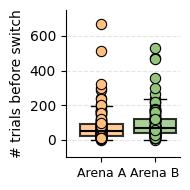

In [24]:
# Box plot — block length by task
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

palette = {24: colors[0], 29: colors[1]} 

block_len_df = (
    subject_data[['task', 'block_id', 'block_len']]
      .drop_duplicates()
      .reset_index(drop=True)
)

Intensity_len = block_len_df.loc[block_len_df['task'] == 24, 'block_len']
Cr_len = block_len_df.loc[block_len_df['task'] == 29, 'block_len']
data = [Intensity_len, Cr_len]

bp = ax.boxplot(
    data,
    patch_artist=True,
    widths=0.6,
    positions=[1.0, 1.75],
    boxprops    = dict(edgecolor='black',linewidth = 1.5),
    medianprops = dict(color='black', linewidth=1.5),
    whiskerprops= dict(color='black'),
    capprops    = dict(color='black')
)

box_colors = [palette[24], palette[29]]
for box, col in zip(bp['boxes'], box_colors):
    box.set_facecolor(col)
    box.set_alpha(0.8) 

rng      = np.random.default_rng(1)
jitter   = 0
dot_area = 55

# Intensity dots (blue)
x24 = 1 + rng.uniform(-jitter, jitter, len(Intensity_len))
ax.scatter(
    x24, Intensity_len,
    marker='o',
    s=dot_area,
    facecolors=palette[24],   # your blue
    edgecolors='black',
    linewidths=0.8,
    zorder=2
)

# CR dots (orange)
x29 = 1.75 + rng.uniform(-jitter, jitter, len(Cr_len))
ax.scatter(
    x29, Cr_len,
    marker='o',
    s=dot_area,
    facecolors=palette[29],   # your orange
    edgecolors='black',
    linewidths=0.8,
    zorder=2
)

ax.set_ylim([-100,750])
ax.set_xlim([0.5, 2.1])
ax.set_xticklabels(['Arena A', 'Arena B'], fontsize = 9)
ax.set_ylabel('# trials before switch')
ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('figures/switch_frequency.pdf',bbox_inches='tight')
plt.show()

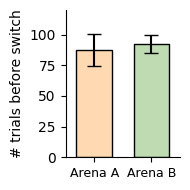

In [25]:
face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[1], 0.6)

means = [Intensity_len.mean(),  Cr_len.mean()]
sems  = [Intensity_len.std(ddof=1) / np.sqrt(len(Intensity_len)),
         Cr_len.std(ddof=1)      / np.sqrt(len(Cr_len))]

# bar centres match your old box positions
xpos  = [0.2, 0.6]

fig, ax = plt.subplots(figsize=(2, 2))

# --- bars ---
ax.bar(xpos, means,
       yerr=sems,
       width=0.25,
       capsize=5,
       color=[face_A, face_B],
       edgecolor='black',
       linewidth=1)


# --- axes styling ---
ax.set_ylim([0, 120])
ax.set_xlim([0, 0.8])
ax.set_xticks(xpos, ['Arena A', 'Arena B'], fontsize=9)
ax.set_ylabel('# trials before switch', fontsize = 10)
# ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/switch_frequency_barplot.svg',bbox_inches='tight', format = 'svg')
plt.show()

In [26]:
t_stat, p_val = stats.ttest_ind(Intensity_len, Cr_len, equal_var=False)  # Welch’s t-test
if p_val > 0.05:
    print(f'Subject stays in either arena does not significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
Intensity_len_mean = np.mean(Intensity_len)
Intensity_len_se = Intensity_len.std(ddof=1) / np.sqrt(len(Intensity_len))
Cr_len_mean = np.mean(Cr_len)
Cr_len_se = Cr_len.std(ddof=1) / np.sqrt(len(Cr_len))
print(f'Intensity task on average runs for {Intensity_len_mean} trials +- {Intensity_len_se:.2f}')
print(f'Click Rate task on average runs for {Cr_len_mean} trials +- {Cr_len_se:.2f}')

Subject stays in either arena does not significantly differ: t = -0.352,  p = 0.7255
Intensity task on average runs for 87.39716312056737 trials +- 12.81
Click Rate task on average runs for 92.56737588652483 trials +- 7.23


**How many trials per day**

In [27]:
# subject_data = ALL.loc[ALL.subjects == subject].reset_index(drop=True)
# subject_data = subject_data.sort_values("times").reset_index(drop=True)
subject_data["trial_idx"] = subject_data.index

# (a) contiguous-block labels
subject_data['day_id'] = subject_data['day'].ne(
    subject_data['day'].shift()
).cumsum()

# (b) trial index *within* each day
subject_data['within_day_idx'] = (
    subject_data
      .groupby('day_id')
      .cumcount()
)

# (c) daily trial length
daily_trial_len = (
    subject_data.groupby('day_id')
    .size()
    .rename('daily_trial_len')
)
subject_data = subject_data.join(daily_trial_len, on='day_id')

daily_len_df = (
    subject_data[['task', 'day_id', 'daily_trial_len']]
      .drop_duplicates()
      .reset_index(drop=True)
)

Intensity_daily_len = daily_len_df.loc[daily_len_df['task'] == 24, 'daily_trial_len']
Cr_daily_len = daily_len_df.loc[daily_len_df['task'] == 29, 'daily_trial_len']

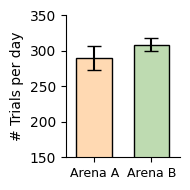

In [28]:
face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[1], 0.6)

means = [Intensity_daily_len.mean(),  Cr_daily_len.mean()]
sems  = [Intensity_len.std(ddof=1) / np.sqrt(len(Intensity_daily_len)),
         Cr_daily_len.std(ddof=1)      / np.sqrt(len(Cr_daily_len))]

# bar centres match your old box positions
xpos  = [0.2, 0.6]

fig, ax = plt.subplots(figsize=(2, 2))

# --- bars ---
ax.bar(xpos, means,
       yerr=sems,
       width=0.25,
       capsize=5,
       color=[face_A, face_B],
       edgecolor='black',
       linewidth=1)


# --- axes styling ---
ax.set_ylim([150, 350])
ax.set_xlim([0, 0.8])
ax.set_xticks(xpos, ['Arena A', 'Arena B'], fontsize=9)
ax.set_ylabel('# Trials per day', fontsize = 10)
# ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/daily_trials_barplot.svg',bbox_inches='tight', format = 'svg')
plt.show()

**How many sessions per day**

In [29]:
session_df = (subject_data
                     .groupby(['day', 'task'])['block_id']
                     .nunique()
                     .reset_index()
                     .rename(columns={'block_id': 'n_sessions'}))
Intensity_session_len = session_df.loc[session_df['task'] == 24, 'n_sessions']
Cr_session_len = session_df.loc[session_df['task'] == 29, 'n_sessions']

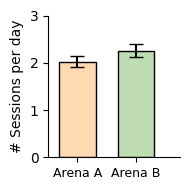

In [30]:
face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[1], 0.6)

means = [Intensity_session_len.mean(),  Cr_session_len.mean()]
sems  = [Intensity_session_len.std(ddof=1) / np.sqrt(len(Intensity_session_len)),
         Cr_session_len.std(ddof=1)      / np.sqrt(len(Cr_session_len))]

# bar centres match your old box positions
xpos  = [0.2, 0.6]

fig, ax = plt.subplots(figsize=(2, 2))

# --- bars ---
ax.bar(xpos, means,
       yerr=sems,
       width=0.25,
       capsize=5,
       color=[face_A, face_B],
       edgecolor='black',
       linewidth=1)


# --- axes styling ---
ax.set_ylim([0, 3])
ax.set_xlim([0, 0.9])
ax.set_xticks(xpos, ['Arena A', 'Arena B'], fontsize=9)
ax.set_ylabel('# Sessions per day', fontsize = 10)
# ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/daily_sessions_barplot.svg',bbox_inches='tight', format = 'svg')
plt.show()

**Performance right after switch**

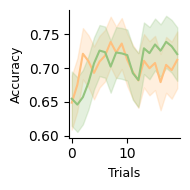

In [31]:
max_k = 20                                      # how many trials to keep

trimmed = subject_data[subject_data['within_block_idx'] < max_k].copy()

summ = (
    trimmed
      .groupby(['task', 'within_block_idx'])['outcomes']
      .agg(mean='mean', count='count', std='std')
      .reset_index()
)
summ['sem'] = summ['std'] / np.sqrt(summ['count'])

#smoothing
for col in ['mean', 'sem']:
    summ[f'smooth_{col}'] = (
        summ
          .groupby('task')[col]
          .transform(lambda s: s.rolling(3,
                                         center=True,
                                         min_periods=1).mean())
    )

fig, ax = plt.subplots(figsize=(2, 2))

for task_val in (24, 29):
    g  = summ[summ['task'] == task_val]
    x  = g['within_block_idx']
    m  = g['smooth_mean']
    se = g['smooth_sem']
    cur_label = 'Arena A' if task_val == 24 else 'Arena B'
    ax.plot(x, m, color=palette[task_val], label=cur_label)
    ax.fill_between(x, m - se, m + se,
                    color=palette[task_val], alpha=0.25)


# ax.axhline(0.8, color='red', ls='--')
# ax.axhline(0.5, color='black', ls='--')
ax.set_xlim(-0.5, max_k - 0.5)
ax.set_xlabel('Trials', fontsize = 9)
ax.set_ylabel('Accuracy',fontsize = 9)
# ax.set_ylim(0.55, 0.85)  
# ax.set_yticks(np.arange(0.6, 0.8, 0.05))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('figures/after_switch_accuray.pdf',bbox_inches='tight')
plt.show()

**number of trials to plateau the performance**

In [32]:
def trials_to_plateau(block_df,
                      plateau_type='max',   # 'mean' | 'max'
                      roll_window=3,         # width of smoothing window (trials)
                      tol=0.02):             # how close is “close enough” (e.g. 0.02 = ±2 p.p.)
    """
    Return the FIRST trial index (1-based) at which a smoothed accuracy trace
    rises to within `tol` of the plateau value *and stays there*.
    
    Parameters
    ----------
    block_df : DataFrame
        One block (arena stay), must contain 'within_block_idx' (0-based) and 'outcomes' (0/1).
    plateau_type : {'mean', 'max'}
        • 'mean' → plateau = block mean accuracy  
        • 'max'  → plateau = max accuracy achieved in the block
    roll_window : int
        Rolling-mean window (in trials) used to smooth accuracy before thresholding.
    tol : float
        Allowed distance below the plateau value that still counts as “on plateau”.

    Returns
    -------
    int | np.nan
        Trial number where plateau is first reached, or NaN if never reached.
    """
    # chronological order
    g = block_df.sort_values('within_block_idx')
    
    # smoothed running performance (centered rolling mean)
    smooth = (g['outcomes']
              .rolling(roll_window, center=True, min_periods=1)
              .mean())
    
    # plateau value
    if plateau_type == 'mean':
        plateau_val = g['outcomes'].mean()
    elif plateau_type == 'max':
        plateau_val = g['outcomes'].max()
    else:
        raise ValueError("plateau_type must be 'mean' or 'max'")
    
    # threshold for “good enough”
    thresh = plateau_val - tol
    
    # first trial where smoothed perf ≥ thresh
    reached = np.flatnonzero(smooth >= thresh)
    if reached.size == 0:
        return np.nan
    
    # +1 so that Trial 0 (index) → Trial 1 (human-readable)
    return int(g.iloc[reached[0]]['within_block_idx'] + 1)

In [37]:
max_k = 20
trimmed = subject_data #[subject_data['within_block_idx'] < max_k]

# list of dicts → DataFrame
records = []
for (task, block_id), block_df in trimmed.groupby(['task', 'block_id']):
    ttp = trials_to_plateau(block_df,
                            plateau_type='mean',  # or 'max'
                            roll_window=10,
                            tol=0.02)
    records.append({'task': task,
                    'block_id': block_id,
                    'trials_to_plateau': ttp})

ttp_df = pd.DataFrame(records).dropna()

stats = (ttp_df
         .groupby('task')['trials_to_plateau']
         .agg(mean='mean',  # bar height
              count='count',
              std='std')
         .assign(sem=lambda d: d['std'] / np.sqrt(d['count'])))

stats

,mean,count,std,sem
task,,,,
24,4.319149,141,4.623417,0.389362
29,4.645390,141,5.540932,0.466631


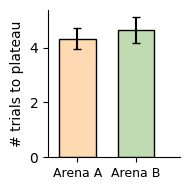

In [38]:
fig, ax = plt.subplots(figsize=(2, 2))
face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
face_B = mcolors.to_rgba(colors[1], 0.6)
bar_colors = [face_A,face_B]   # reuse your palette

x = [0.2,0.6]
ax.bar(x,
       height=stats['mean'],
       yerr=stats['sem'],
       color=bar_colors,
       edgecolor='black',
       width=0.25,
       capsize=3)

ax.set_xlim([0, 0.9])
ax.set_xticks(x)
ax.set_xticklabels(['Arena A', 'Arena B'],fontsize = 9)
ax.set_ylabel('# trials to plateau',fontsize = 10)

ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.rcParams["svg.fonttype"] = "none"
plt.savefig('figures/grant/svg/trials_to_plateau.svg',bbox_inches='tight', format = 'svg')
plt.show()